In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import imghdr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = "/content/drive/MyDrive/data"

In [4]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issue with image {}".format(image_path))

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data')

Found 161 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[0].max()

255.0

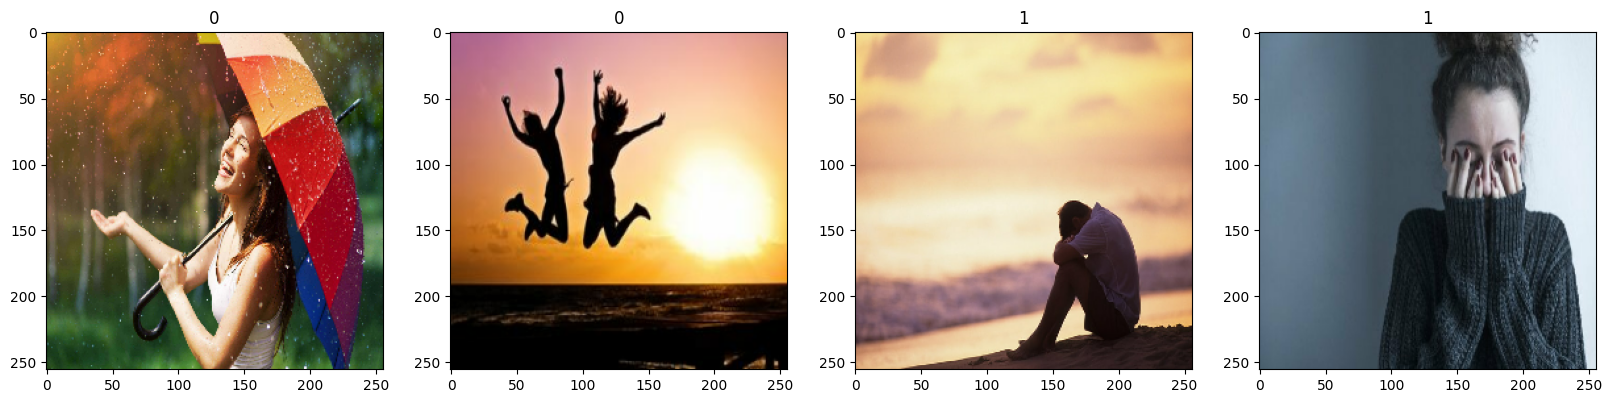

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [13]:
scaled = batch[0] / 255

In [14]:
scaled.max()

1.0

In [15]:
data = data.map(lambda x, y: (x / 255, y))

In [16]:
scale_iterator = data.as_numpy_iterator()

In [17]:
scale_iterator.next()[0].max()

1.0

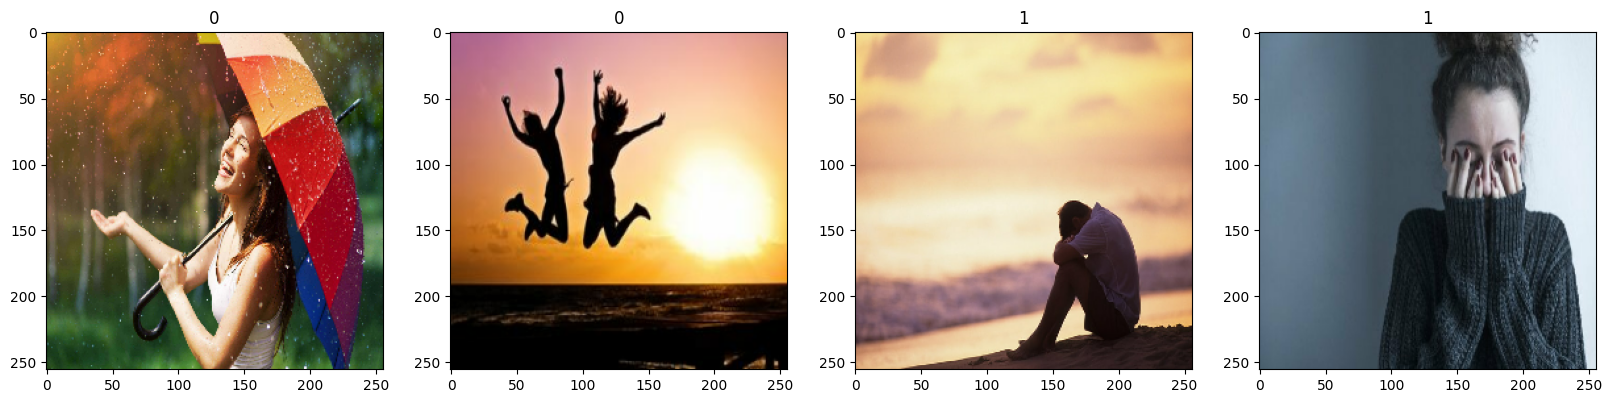

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [19]:
len(data)

6

In [20]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)+1

In [21]:
train_size+val_size+test_size

6

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [28]:
logdir = 'logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 22s 5s/step - loss: 1.3709 - accuracy: 0.5469 - val_loss: 0.6693 - val_accuracy: 0.5312
Epoch 2/20
4/4 [==============================] - 15s 3s/step - loss: 0.6810 - accuracy: 0.5391 - val_loss: 0.5713 - val_accuracy: 0.7812
Epoch 3/20
4/4 [==============================] - 15s 3s/step - loss: 0.6194 - accuracy: 0.6328 - val_loss: 0.5863 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 16s 4s/step - loss: 0.5960 - accuracy: 0.6250 - val_loss: 0.4455 - val_accuracy: 0.7812
Epoch 5/20
4/4 [==============================] - 15s 3s/step - loss: 0.4880 - accuracy: 0.7891 - val_loss: 0.4339 - val_accuracy: 0.8125
Epoch 6/20
4/4 [==============================] - 15s 3s/step - loss: 0.4715 - accuracy: 0.8125 - val_loss: 0.5124 - val_accuracy: 0.7500
Epoch 7/20
4/4 [==============================] - 15s 4s/step - loss: 0.3896 - accuracy: 0.8438 - val_loss: 0.3936 - val_accuracy: 0.8750
Epoch 8/20
4/4 [==================

In [31]:
from matplotlib import pyplot as plt

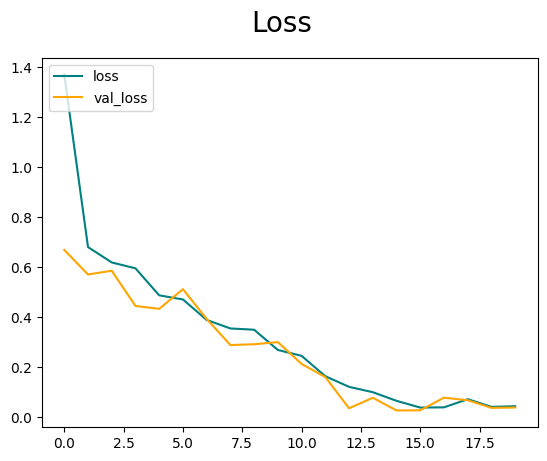

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

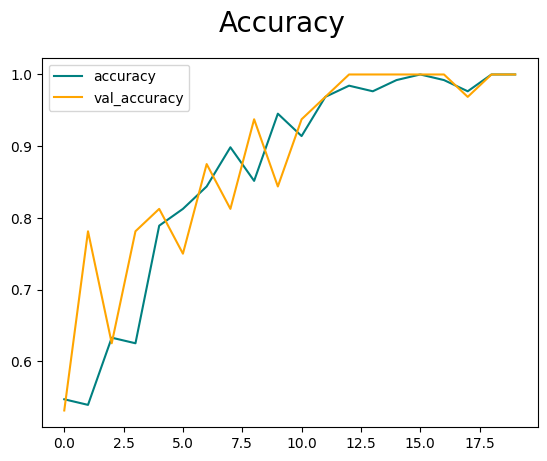

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 253ms/step


In [37]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


In [38]:
import cv2

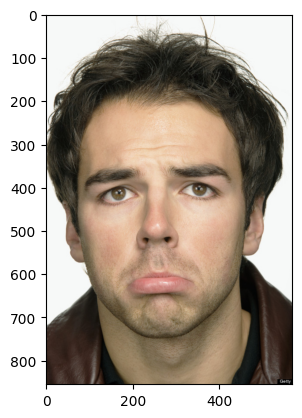

In [39]:
img = cv2.imread('/content/drive/MyDrive/image_classification/sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

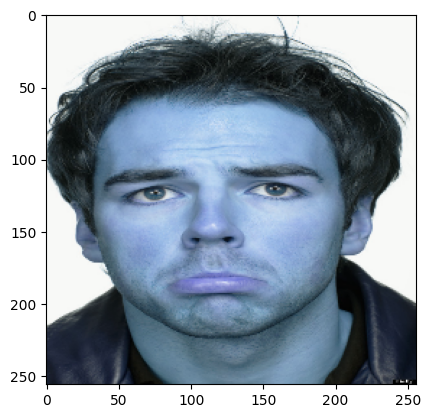

In [40]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 41ms/step


In [42]:
yhat

array([[0.9995034]], dtype=float32)

In [43]:
if yhat > 0.5:
  print(f"Predicted class is Sad")
else:
  print(f"Predicted class is Happy")

Predicted class is Sad


In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('/content/drive/MyDrive/models', 'happysadclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
new_model = load_model(os.path.join('/content/drive/MyDrive/models', 'happysadclassifier.h5'))

In [47]:
new_model

In [48]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 154ms/step


In [49]:
if yhatnew > 0.5:
  print(f"Predicted class is Sad")
else:
  print(f"Predicted class is Happy")

Predicted class is Sad
